## In this Notebook
* examples of applications of ADI 


In [145]:
using Random
using LinearAlgebra
using SparseArrays
using Plots
using Statistics

### Dynamical Systems
Given $x,u,y$ as state, input, and output vectors, we can work with the simple discrete-time linear system representing

$$\dot{x}=A x+B u, \quad y=C x$$

An example is a balance system. In this case, if $u$ is a horizontal vector

$$A = \left[\begin{array}{ccccc}{0} & {1} & {0} & {\dots} & {0} \\ {0} & {0} & {1} & {\dots} & {0} \\ {\vdots} & {} & {} & {\ddots} & {} \\ {0} & {} & {} & {} & {1} \\ {-a_{n}} & {-a_{n-1}} & {\dots} & {} & {-a_{1}}\end{array}\right], B = \left[\begin{array}{c}{0} \\ {0} \\ {\vdots} \\ {0} \\ {1}\end{array}\right], C = \left[\begin{array}{llll}{b_{n}} & {b_{n-1}} & {\ldots} & {b_{1}}\end{array}\right]^T $$


This is based on the system on page 40 of [this systems modelling textbook](https://www.cds.caltech.edu/~murray/courses/cds101/fa04/caltech/am04_ch2-3oct04.pdf).

The Sylvester equation arises in the Sylvester controller equation, which is included in the Control Theory section below.

In [63]:
function gen_balance(n)
    A = zeros((n-1,n-1)) + I
    a = rand(n) .-1
    A = [zeros(n-1) A; a']
    B = zeros(n) 
    B[end] = 1
    C = rand(n)'
    return A,B,C
end

gen_balance (generic function with 1 method)

In [65]:
A,B,C = gen_balance(n)
display("text/plain",A)
display("text/plain",B)
display("text/plain",C)

10×10 Array{Float64,2}:
  0.0        1.0        0.0       …   0.0        0.0        0.0     
  0.0        0.0        1.0           0.0        0.0        0.0     
  0.0        0.0        0.0           0.0        0.0        0.0     
  0.0        0.0        0.0           0.0        0.0        0.0     
  0.0        0.0        0.0           0.0        0.0        0.0     
  0.0        0.0        0.0       …   0.0        0.0        0.0     
  0.0        0.0        0.0           1.0        0.0        0.0     
  0.0        0.0        0.0           0.0        1.0        0.0     
  0.0        0.0        0.0           0.0        0.0        1.0     
 -0.158764  -0.356223  -0.881882     -0.388179  -0.669568  -0.715412

10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

1×10 Adjoint{Float64,Array{Float64,1}}:
 0.639791  0.652148  0.780869  0.059386  …  0.0826559  0.532068  0.734294

### PDE

The example below is the 2D heat equation, or

$$u' = \alpha \nabla ^2 u$$

The boundary conditions are randomly generated in the function below.

In [2]:
function gen_2dheat(n)
    h = 1 / (n - 1) # resolution of the discretization
    A = (1 / h^2) * SymTridiagonal(2 * ones(n), -1 * ones(n-1));
    tau = 0.2
    x = repeat([collect(1:1:n)],n)
    x = hcat(x...)
    y = x'
    C = log.(tau .+ abs.(x - y))
    
    return A,C
end

gen_2dheat (generic function with 1 method)

In [61]:
A,C = gen_2dheat(10)
display("text/plain",A)
display("text/plain",C)

10×10 SymTridiagonal{Float64,Array{Float64,1}}:
 162.0  -81.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
 -81.0  162.0  -81.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅   -81.0  162.0  -81.0     ⋅      ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅   -81.0  162.0  -81.0     ⋅      ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅   -81.0  162.0  -81.0     ⋅      ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅   -81.0  162.0  -81.0     ⋅      ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅   -81.0  162.0  -81.0     ⋅      ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -81.0  162.0  -81.0     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -81.0  162.0  -81.0
    ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅      ⋅   -81.0  162.0

10×10 Array{Float64,2}:
 -1.60944    0.182322   0.788457  …   1.97408    2.10413    2.2192  
  0.182322  -1.60944    0.182322      1.82455    1.97408    2.10413 
  0.788457   0.182322  -1.60944       1.64866    1.82455    1.97408 
  1.16315    0.788457   0.182322      1.43508    1.64866    1.82455 
  1.43508    1.16315    0.788457      1.16315    1.43508    1.64866 
  1.64866    1.43508    1.16315   …   0.788457   1.16315    1.43508 
  1.82455    1.64866    1.43508       0.182322   0.788457   1.16315 
  1.97408    1.82455    1.64866      -1.60944    0.182322   0.788457
  2.10413    1.97408    1.82455       0.182322  -1.60944    0.182322
  2.2192     2.10413    1.97408       0.788457   0.182322  -1.60944 

### Control Theory

We look at the Sylvester-controller equation

$$TX - XA = -GC $$

The following code will generate an arbitrary $A$ and $B$ to frame the problem, a $T$ constructed based on a random spectrum $\Omega$, and $G$  chosen such that $(T,G)$ is controllable.

In [60]:
function state_estimation(n)
    A,B,C = gen_balance(n)
    evals = rand(n) .- 2
    T = zeros((n,n))
    T[diagind(T,0)] = evals
    T[diagind(T,-1)] .= 1
    G = zeros(n) 
    G[1] = 1
    return A,T,B,G
end

state_estimation (generic function with 1 method)

In [59]:
A,T, G = state_estimation(10)
display("text/plain",A)
display("text/plain",T)
display("text/plain",G)

10×10 Array{Float64,2}:
  0.0         1.0        0.0       …   0.0        0.0        0.0     
  0.0         0.0        1.0           0.0        0.0        0.0     
  0.0         0.0        0.0           0.0        0.0        0.0     
  0.0         0.0        0.0           0.0        0.0        0.0     
  0.0         0.0        0.0           0.0        0.0        0.0     
  0.0         0.0        0.0       …   0.0        0.0        0.0     
  0.0         0.0        0.0           1.0        0.0        0.0     
  0.0         0.0        0.0           0.0        1.0        0.0     
  0.0         0.0        0.0           0.0        0.0        1.0     
 -0.0453961  -0.110601  -0.019793     -0.231459  -0.551584  -0.491182

10×10 Array{Float64,2}:
 -0.917166   0.0       0.0       …   0.0        0.0        0.0     
  1.0       -0.51677   0.0           0.0        0.0        0.0     
  0.0        1.0      -0.614719      0.0        0.0        0.0     
  0.0        0.0       1.0           0.0        0.0        0.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0       …   0.0        0.0        0.0     
  0.0        0.0       0.0           0.0        0.0        0.0     
  0.0        0.0       0.0          -0.510934   0.0        0.0     
  0.0        0.0       0.0           1.0       -0.841421   0.0     
  0.0        0.0       0.0           0.0        1.0       -0.803667

10-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

### Image Denoising
For this set of examples, the noisy image is generated from one of the Julia samples. The image can be changed to provide other examples.

$$\hat{F} \Phi_{x}+\sigma_{\eta}^{2} \Phi_{y}^{-1} \hat{F}=G \Phi_{x}$$

We create the distorted image $G$ by adding Gaussian noise. The approximation of the original image is $\hat F$.

In [176]:
using TestImages
using Images, ImageView

┌ Info: Precompiling ImageView [86fae568-95e7-573e-a6b2-d8a6b900c9ef]
└ @ Base loading.jl:1242


In [169]:
function gen_imagedenoise(name)
    rng = MersenneTwister(1234);
    img = testimage(name)
    gimg = Gray.(img)
    channels = float(channelview(gimg))
    
    n,m = size(gimg)
    eta = rand(1)[1]
    noise = zeros((n,m))
    randn!(rng,noise)
    
    G = noise + channels
    
    covx = cov(vec(G'), vec(G'))
    covy = cov(vec(G), vec(G))
    coveta = cov(vec(noise), vec(noise))
    
    return G, covx, covy, coveta
end

gen_imagedenoise (generic function with 1 method)

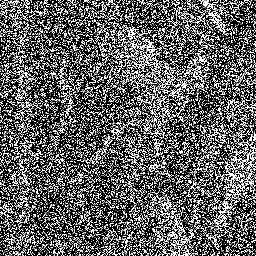

In [178]:
G, covx, covy, coveta = gen_imagedenoise("lena_gray_16bit")
G = channels + noise
Gray.(G)